<a href="https://colab.research.google.com/github/vibhananda28/Machine-Learning-Projects/blob/main/project1_tweets_vibhananda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### IMPORT LIBRARIES

In [ ]:
#Import libraries
!pip install emoji
import os
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from more_itertools import take
from nltk import word_tokenize
from typing import List
from more_itertools import take
import pickle
import nltk
import emoji
import csv
import spacy
import copy
import warnings
from itertools import chain
warnings.filterwarnings("ignore")
import re
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import AgglomerativeClustering

##### READ THE DATA FROM THE 16 TEXT FILES, COLLATE THEM AND OUTPUT THEM INTO CSV

In [ ]:
#Read the text files
data_folder = "./Data"
data_files = [file for file in os.listdir(data_folder) if file.endswith(".txt")]

# Parse and combine the data from .txt files
final_dataset = []

for data_file in data_files:
    with open(os.path.join(data_folder, data_file), 'r', encoding='unicode_escape') as file:
        for line in file:
            tweet_parts = line.strip().split('|')
            if len(tweet_parts) == 3:
                tweet_data = {
                    'account': data_file.split('.')[0],
                    'tweet_id': tweet_parts[0],
                    'date_time': tweet_parts[1],
                    'tweet': tweet_parts[2]
                }
                final_dataset.append(tweet_data)

#Save the collated dataset
output_file = "./Data/final_dataset.csv"
with open(output_file, 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = ['account', 'tweet_id', 'date_time', 'tweet']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for tweet in final_dataset:
        writer.writerow(tweet)

print("Collated tweets dataset saved to", output_file)

##### EXPLORE DATA USING THE COLLATED DATA IN THE FINAL CSV FILE

In [ ]:
#Read the collated final dataset
df = pd.read_csv("./final_dataset.csv")

In [ ]:
df.head(15)

account            tweet_id                       date_time  \
0   cbchealth  586266687948881921  Thu Apr 09 20:37:25 +0000 2015   
1   cbchealth  586266687017771008  Thu Apr 09 20:37:25 +0000 2015   
2   cbchealth  586266685495214080  Thu Apr 09 20:37:24 +0000 2015   
3   cbchealth  586226316820623360  Thu Apr 09 17:57:00 +0000 2015   
4   cbchealth  586164344452354048  Thu Apr 09 13:50:44 +0000 2015   
5   cbchealth  586164343701508096  Thu Apr 09 13:50:44 +0000 2015   
6   cbchealth  586143262810845184  Thu Apr 09 12:26:58 +0000 2015   
7   cbchealth  586104681849425921  Thu Apr 09 09:53:40 +0000 2015   
8   cbchealth  586104681136398337  Thu Apr 09 09:53:39 +0000 2015   
9   cbchealth  585923818805276672  Wed Apr 08 21:54:58 +0000 2015   
10  cbchealth  585906983091376128  Wed Apr 08 20:48:05 +0000 2015   
11  cbchealth  585855618738589696  Wed Apr 08 17:23:58 +0000 2015   
12  cbchealth  585819838821576705  Wed Apr 08 15:01:48 +0000 2015   
13  cbchealth  585731543282376704  Wed Apr 08 09:10:56 +0000 2015   
14  cbchealth  585579956371066880  Tue Apr 07 23:08:35 +0000 2015   

                                                tweet  
0   Drugs need careful monitoring for expiry dates...  
1   Sabra hummus recalled in U.S. http://www.cbc.c...  
2   U.S. sperm bank sued by Canadian couple didn't...  
3   Manitoba pharmacists want clampdown on Tylenol...  
4   Mom of 7 'spooked' by vaccinations reverses st...  
5   Hamilton police send mental health pros to the...  
6   Wind turbine noise linked to only 1 health iss...  
7   'Wild West' of e-cigarettes sparks debate over...  
8   Dementia patients sold unproven 'brainwave opt...  
9   Passengers on second China-Vancouver flight in...  
10  Check expiry dates, Health Canada advises afte...  
11  Hashtagging eating disorders: help or hindranc...  
12  Obama says memory of daughter's preschool asth...  
13  Women Into Healing accused of failing drug add...  
14  Expired Alesse birth control exposes 'deficien...

##### BASIC EDA

In [ ]:
df.shape

(63112, 4)

The dataset contains 63112 rows and 4 columns.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63112 entries, 0 to 63111
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   account    63112 non-null  object
 1   tweet_id   63112 non-null  int64 
 2   date_time  63112 non-null  object
 3   tweet      63112 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.9+ MB


All the 4 columns contain non-null rows, hence, no missing values.

In [ ]:
df['account'].value_counts()

goodhealth          7795
nytimeshealth       6144
nprhealth           4837
reuters_health      4719
NBChealth           4215
latimeshealth       4171
cnnhealth           4049
bbchealth           3929
cbchealth           3728
KaiserHealthNews    3508
everydayhealth      3239
wsjhealth           3200
msnhealthnews       3199
gdnhealthcare       2979
foxnewshealth       2000
usnewshealth        1400
Name: account, dtype: int64

In [ ]:
df['account'].nunique()

16

##### PREPROCESSING

CLEAN TWEETS BY REMOVING LINKS, NON ALPHA NUMERIC SIGNS, EMOJIS ETC.

In [ ]:
def clean_text(tweet):
    tweet = re.sub("@[A-Za-z0-9]+","",tweet) #Remove @ sign
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) #Remove http links
    tweet = " ".join(tweet.split())
    tweet = tweet.lower()
    tweet = ''.join(c for c in tweet if c not in emoji.EMOJI_DATA) #Remove Emojis
    tweet = re.sub('[^A-Za-z0-9]+', ' ', tweet)
    tweet = tweet.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
    return tweet

#SOURCE: https://stackoverflow.com/questions/64719706/cleaning-twitter-data-pandas-python. This code was used to avoid using multiple function like I had been doing in previous courses, and it handled certain things better than I had in the past.

In [ ]:
df['cleaned_tweet'] = df['tweet'].map(lambda x: clean_text(x))

In [ ]:
df.head()

account            tweet_id                       date_time  \
0  cbchealth  586266687948881921  Thu Apr 09 20:37:25 +0000 2015   
1  cbchealth  586266687017771008  Thu Apr 09 20:37:25 +0000 2015   
2  cbchealth  586266685495214080  Thu Apr 09 20:37:24 +0000 2015   
3  cbchealth  586226316820623360  Thu Apr 09 17:57:00 +0000 2015   
4  cbchealth  586164344452354048  Thu Apr 09 13:50:44 +0000 2015   

                                               tweet  \
0  Drugs need careful monitoring for expiry dates...   
1  Sabra hummus recalled in U.S. http://www.cbc.c...   
2  U.S. sperm bank sued by Canadian couple didn't...   
3  Manitoba pharmacists want clampdown on Tylenol...   
4  Mom of 7 'spooked' by vaccinations reverses st...   

                                       cleaned_tweet  
0  drugs need careful monitoring for expiry dates...  
1                      sabra hummus recalled in u s   
2  u s sperm bank sued by canadian couple didn t ...  
3  manitoba pharmacists want clampdown on tylenol...  
4  mom of 7 spooked by vaccinations reverses stan...

TOKENIZE CLEANED TWEETS FOR FURTHER ANALYSIS

In [ ]:
nltk.download('words')
words = set(nltk.corpus.words.words())
nltk.download('punkt')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
df['tokenized_cleaned_tweet'] = df['cleaned_tweet'].apply(lambda x: word_tokenize(x))

In [ ]:
df[['cleaned_tweet', 'tokenized_cleaned_tweet']].head(15)

cleaned_tweet  \
0   drugs need careful monitoring for expiry dates...   
1                       sabra hummus recalled in u s    
2   u s sperm bank sued by canadian couple didn t ...   
3   manitoba pharmacists want clampdown on tylenol...   
4   mom of 7 spooked by vaccinations reverses stan...   
5   hamilton police send mental health pros to the...   
6   wind turbine noise linked to only 1 health iss...   
7    wild west of e cigarettes sparks debate over ...   
8   dementia patients sold unproven brainwave opti...   
9   passengers on second china vancouver flight in...   
10  check expiry dates health canada advises after...   
11  hashtagging eating disorders help or hindrance...   
12  obama says memory of daughter s preschool asth...   
13  women into healing accused of failing drug add...   
14   expired alesse birth control exposes deficiency    

                              tokenized_cleaned_tweet  
0   [drugs, need, careful, monitoring, for, expiry...  
1                 [sabra, hummus, recalled, in, u, s]  
2   [u, s, sperm, bank, sued, by, canadian, couple...  
3   [manitoba, pharmacists, want, clampdown, on, t...  
4   [mom, of, 7, spooked, by, vaccinations, revers...  
5   [hamilton, police, send, mental, health, pros,...  
6   [wind, turbine, noise, linked, to, only, 1, he...  
7   [wild, west, of, e, cigarettes, sparks, debate...  
8   [dementia, patients, sold, unproven, brainwave...  
9   [passengers, on, second, china, vancouver, fli...  
10  [check, expiry, dates, health, canada, advises...  
11  [hashtagging, eating, disorders, help, or, hin...  
12  [obama, says, memory, of, daughter, s, prescho...  
13  [women, into, healing, accused, of, failing, d...  
14  [expired, alesse, birth, control, exposes, def...

REMOVE STOPWORDS FROM TOKENIZED TWEETS

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [ ]:
df['nostopword_cleaned_tokenized_tweet'] = df['tokenized_cleaned_tweet'].apply(lambda x: [item for item in x if item not in stop])

In [ ]:
pd.set_option('display.max_colwidth', None)
df[['tokenized_cleaned_tweet', 'nostopword_cleaned_tokenized_tweet']].head(20)

tokenized_cleaned_tweet  \
0                             [drugs, need, careful, monitoring, for, expiry, dates, pharmacists, say]   
1                                                                  [sabra, hummus, recalled, in, u, s]   
2       [u, s, sperm, bank, sued, by, canadian, couple, didn, t, verify, donor, info, executive, says]   
3                                      [manitoba, pharmacists, want, clampdown, on, tylenol, 1, sales]   
4                 [mom, of, 7, spooked, by, vaccinations, reverses, stand, but, then, kids, get, sick]   
5                    [hamilton, police, send, mental, health, pros, to, the, front, lines, with, cops]   
6                                [wind, turbine, noise, linked, to, only, 1, health, issue, annoyance]   
7                                    [wild, west, of, e, cigarettes, sparks, debate, over, regulation]   
8                                        [dementia, patients, sold, unproven, brainwave, optimization]   
9              [passengers, on, second, china, vancouver, flight, in, 2, weeks, at, risk, of, measles]   
10    [check, expiry, dates, health, canada, advises, after, alesse, 21, birth, control, pill, recall]   
11                                 [hashtagging, eating, disorders, help, or, hindrance, in, recovery]   
12  [obama, says, memory, of, daughter, s, preschool, asthma, attacks, spurs, climate, change, debate]   
13                    [women, into, healing, accused, of, failing, drug, addicts, by, angry, families]   
14                                              [expired, alesse, birth, control, exposes, deficiency]   
15                [despite, paying, top, dollar, some, military, mental, health, jobs, hard, to, fill]   
16                           [boy, s, severe, peanut, fish, allergies, traced, to, blood, transfusion]   
17                      [weight, watchers, jenny, craig, get, best, marks, in, diet, research, review]   
18                             [cancer, stricken, baby, from, whitehorse, awaiting, liver, transplant]   
19                                          [avian, flu, confirmed, on, turkey, farm, near, woodstock]   

                                                             nostopword_cleaned_tokenized_tweet  
0                           [drugs, need, careful, monitoring, expiry, dates, pharmacists, say]  
1                                                                  [sabra, hummus, recalled, u]  
2                [u, sperm, bank, sued, canadian, couple, verify, donor, info, executive, says]  
3                                   [manitoba, pharmacists, want, clampdown, tylenol, 1, sales]  
4                             [mom, 7, spooked, vaccinations, reverses, stand, kids, get, sick]  
5                            [hamilton, police, send, mental, health, pros, front, lines, cops]  
6                                   [wind, turbine, noise, linked, 1, health, issue, annoyance]  
7                                       [wild, west, e, cigarettes, sparks, debate, regulation]  
8                                 [dementia, patients, sold, unproven, brainwave, optimization]  
9                       [passengers, second, china, vancouver, flight, 2, weeks, risk, measles]  
10    [check, expiry, dates, health, canada, advises, alesse, 21, birth, control, pill, recall]  
11                                  [hashtagging, eating, disorders, help, hindrance, recovery]  
12  [obama, says, memory, daughter, preschool, asthma, attacks, spurs, climate, change, debate]  
13                           [women, healing, accused, failing, drug, addicts, angry, families]  
14                                       [expired, alesse, birth, control, exposes, deficiency]  
15                   [despite, paying, top, dollar, military, mental, health, jobs, hard, fill]  
16                           [boy, severe, peanut, fish, allergies, traced, blood, transfusion]  
17                   [weight, watchers, jenny, craig, get, best, marks, diet, research, 

##### VISUALIZATION TASK

###### 1a. Graph the probability of occurrence for the 10 most common words from each Twitter account.

In [ ]:
df.head()

account            tweet_id                       date_time  \
0  cbchealth  586266687948881921  Thu Apr 09 20:37:25 +0000 2015   
1  cbchealth  586266687017771008  Thu Apr 09 20:37:25 +0000 2015   
2  cbchealth  586266685495214080  Thu Apr 09 20:37:24 +0000 2015   
3  cbchealth  586226316820623360  Thu Apr 09 17:57:00 +0000 2015   
4  cbchealth  586164344452354048  Thu Apr 09 13:50:44 +0000 2015   

                                                                                                                                                                                                             tweet  \
0                                   Drugs need careful monitoring for expiry dates, pharmacists say http://www.cbc.ca/news/health/drugs-need-careful-monitoring-for-expiry-dates-pharmacists-say-1.3026749?cmp=rss   
1                                                                                                       Sabra hummus recalled in U.S. http://www.cbc.ca/news/health/sabra-hummus-recalled-in-u-s-1.3026865?cmp=rss   
2    U.S. sperm bank sued by Canadian couple didn't verify donor info, executive says http://www.cbc.ca/news/canada/toronto/sperm-bank-sued-by-port-hope-couple-says-it-didn-t-verify-donor-info-1.3026909?cmp=rss   
3                                           Manitoba pharmacists want clampdown on Tylenol 1 sales http://www.cbc.ca/news/canada/manitoba/manitoba-pharmacists-want-clampdown-on-tylenol-1-sales-1.3025636?cmp=rss   
4  Mom of 7 'spooked' by vaccinations reverses stand â but then kids get sick http://www.cbc.ca/news/canada/ottawa/tara-hills-ottawa-mom-changes-anti-vaccination-stand-before-7-kids-get-sick-1.3025592?cmp=rss   

                                                                    cleaned_tweet  \
0                  drugs need careful monitoring for expiry dates pharmacists say   
1                                                   sabra hummus recalled in u s    
2  u s sperm bank sued by canadian couple didn t verify donor info executive says   
3                          manitoba pharmacists want clampdown on tylenol 1 sales   
4          mom of 7 spooked by vaccinations reverses stand but then kids get sick   

                                                                          tokenized_cleaned_tweet  \
0                        [drugs, need, careful, monitoring, for, expiry, dates, pharmacists, say]   
1                                                             [sabra, hummus, recalled, in, u, s]   
2  [u, s, sperm, bank, sued, by, canadian, couple, didn, t, verify, donor, info, executive, says]   
3                                 [manitoba, pharmacists, want, clampdown, on, tylenol, 1, sales]   
4            [mom, of, 7, spooked, by, vaccinations, reverses, stand, but, then, kids, get, sick]   

                                               nostopword_cleaned_tokenized_tweet  
0             [drugs, need, careful, monitoring, expiry, dates, pharmacists, say]  
1                                                    [sabra, hummus, recalled, u]  
2  [u, sperm, bank, sued, canadian, couple, verify, donor, info, executive, says]  
3                     [manitoba, pharmacists, want, clampdown, tylenol, 1, sales]  
4               [mom, 7, spooked, vaccinations, reverses, stand, kids, get, sick]

In [ ]:
from collections import Counter

In [ ]:
df2 = df[["account", "nostopword_cleaned_tokenized_tweet"]]

In [ ]:
grouped_df = df2.groupby('account').agg({'nostopword_cleaned_tokenized_tweet': 'sum'})

In [ ]:
grouped_df.head()

nostopword_cleaned_tokenized_tweet
account                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
KaiserHealthNews             [tougher, vaccine, law, calif, clears, first, hurdle, new, sort, extracurricular, activity, seeing, patients, houston, firefighters, another, tool, disposal, answering, calls, digital, doctors, montana, expand, medicaid, program, moderates, revived, idea, rand, paul, campaign, first, day, abortion, budget, enroll, america, group, dedicated, promoting, health, law, sign, ups, cut, 100, jobs, rt, ever, look, health, symptoms, computer, retired, news, director, led, charge, patch, job, obamacare, still, getting, taxes, done, 2014, tax, bill, could, affected, insurance, medicine, use, computer, probably, man, thank, reports, rt, two, doctors, fight, choice, die, via, rt, evidence, support, annual, physicals, reports, info, getting, still, getting, taxes, done, 2014, tax, ...]
NBChealth          [ebola, exposure, cdc, worker, remains, well, pregnant, woman, taken, life, support, ireland, money, icebucketchallenge, still, flowing, als, association, leaders, remain, awestruck, gush, goodwill, caramel, apples, recalled, listeria, deaths, ice, bucket, challenge, still, rains, bucks, als, following, mistake, possible, exposures, cdc, ebola, lab, health, involved, staff, monitored, 21, days, cdc, reports, possible, ebola, exposure, containment, lab, stress, fueled, indulgences, bring, joy, delayed, concussions, common, tricky, gay, groups, decry, fda, rule, requiring, sex, give, blood, fda, plans, ease, ban, blood, donations, gay, men, fda, proposes, easing, ban, blood, donations, gay, men, nearly, 2, million, people, choose, obamacare, beyond, narcan, life, saving, heroin, ...]
bbchealth                                                                                            [breast, cancer, risk, test, devised, gp, workload, harming, care, bma, poll, short, people, heart, risk, greater, new, approach, hiv, promising, coalition, undermined, nhs, doctors, review, case, nhs, manager, video, day, empty, going, video, overhaul, needed, end, life, care, care, dying, needs, overhaul, video, nhs, labour, tory, key, policies, gp, services, got, worse, amp, e, waiting, hits, new, worst, level, parties, row, gp, opening, hours, strenuous, runs, may, bad, video, health, surcharge, non, eu, patients, video, skin, cancer, spike, 60s, holidays, 80, 000, might, die, future, outbreak, skin, cancer, linked, holiday, boom, public, back, tax, rises, fund, nhs, video, welcome, designer, ...]
cbchealth         [drugs, need, careful, monitoring, expiry, dates, pharmacists, say, sabra, hummus, recalled, u, u, sperm, bank, sued, canadian, couple, verify, donor, info, executive, says, manitoba, pharmacists, want, clampdown, tylenol, 1, sales, mom, 7, spooked, vaccinations, reverses, stand, kids, get, sick, hamilton, police, send, mental, health, pros, front, lines, cops, wind, turbine, noise, linked, 1, health, issue, annoyance, wild, west, e, cigarettes, sparks, debate, regulation, dementia, patients, sold, unproven, brainwave, optimization, passengers, second, china, vancouver, flight, 2, weeks, risk, measles, check, expiry, dates, health, canada, advises, alesse, 21, birth, control, pill, recall, 

In [ ]:
def plot_word_probabilities(account,total):
    words, frequencies = zip(*account)
    probability = [x/total for x in frequencies]
    print(probability)
    plt.figure(figsize=(10, 6))
    plt.bar(words, probability)
    plt.xlabel('Words')
    plt.ylabel('Probability')
    plt.title(f'10 Most Common Words in {account}')
    plt.xticks(rotation=45)
    #plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

KaiserHealthNews
[0.035184264716324645, 0.01672228928495349, 0.015160122133068239, 0.014663068948377477, 0.01388198537243485, 0.012816871405240361, 0.01175175743804587, 0.010118582688347652, 0.00901796492224668, 0.00866292693318185]


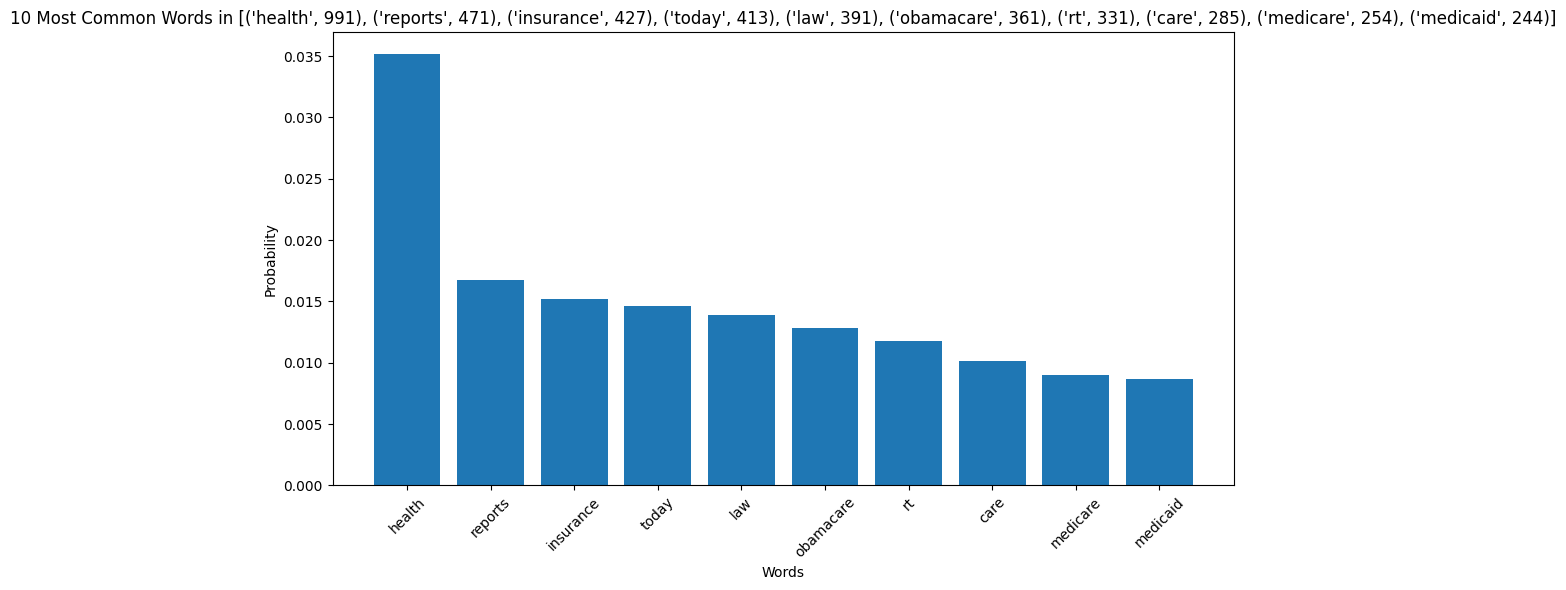

NBChealth
[0.013601127554615927, 0.011663143058491896, 0.010359408033826638, 0.008491895701198026, 0.00828047921071177, 0.007928118393234672, 0.007505285412262156, 0.0066948555320648345, 0.005884425651867513, 0.005003523608174771]


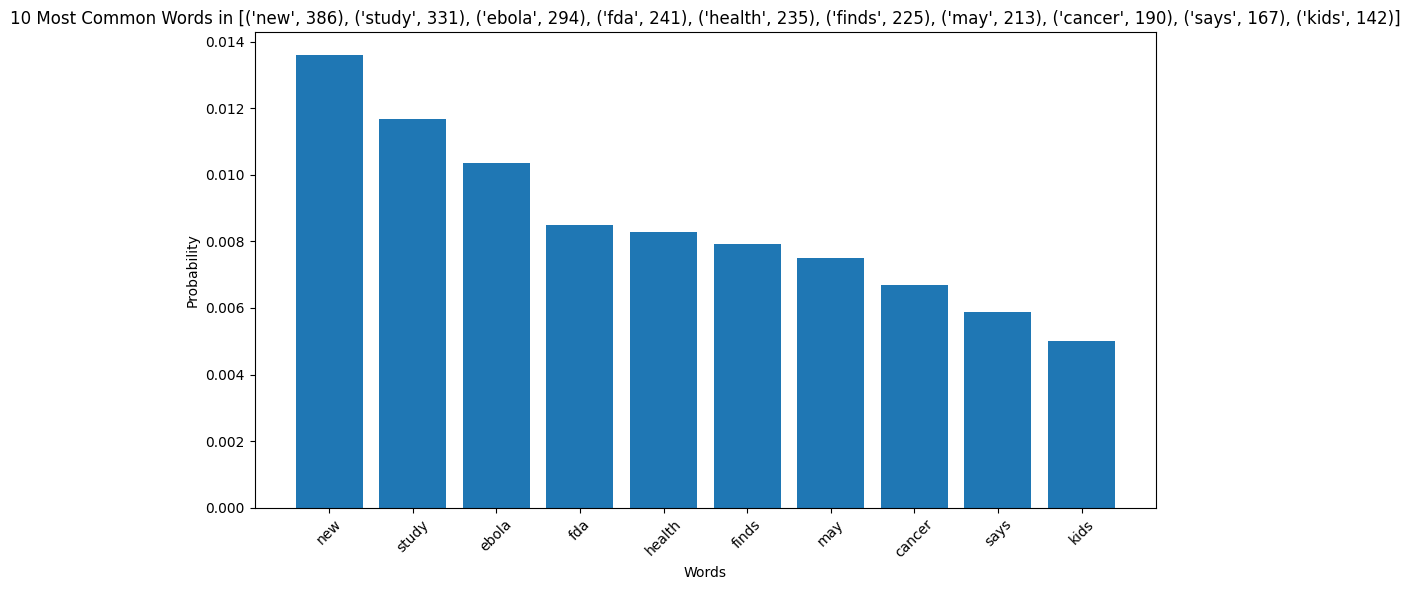

bbchealth
[0.04326539300729072, 0.018945239742429888, 0.018625937949018147, 0.01154808152839125, 0.010324091320312916, 0.009791921664626682, 0.008514714490979724, 0.007450375179607259, 0.006439252833803416, 0.006066734074823054]


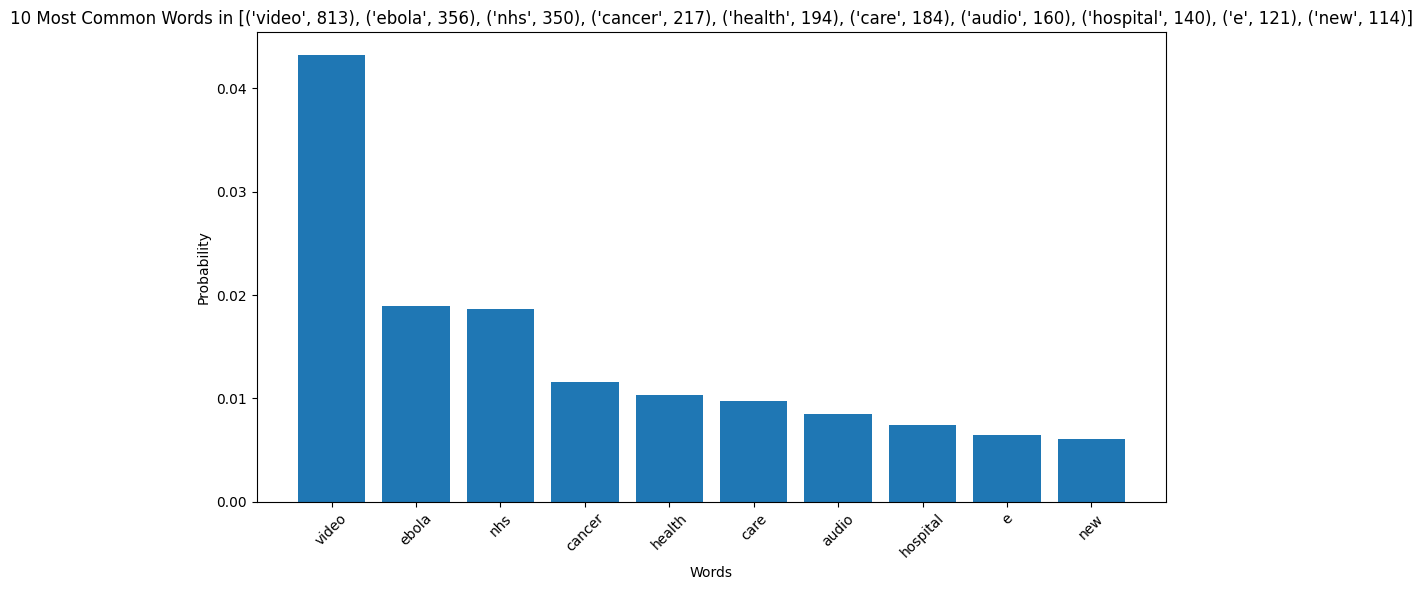

cbchealth
[0.01682787386286002, 0.012620905397145015, 0.008521807917730394, 0.007766711013627701, 0.007155442091258854, 0.005717162273920391, 0.005717162273920391, 0.0056092912876200066, 0.005357592319585776, 0.004962065369817698]


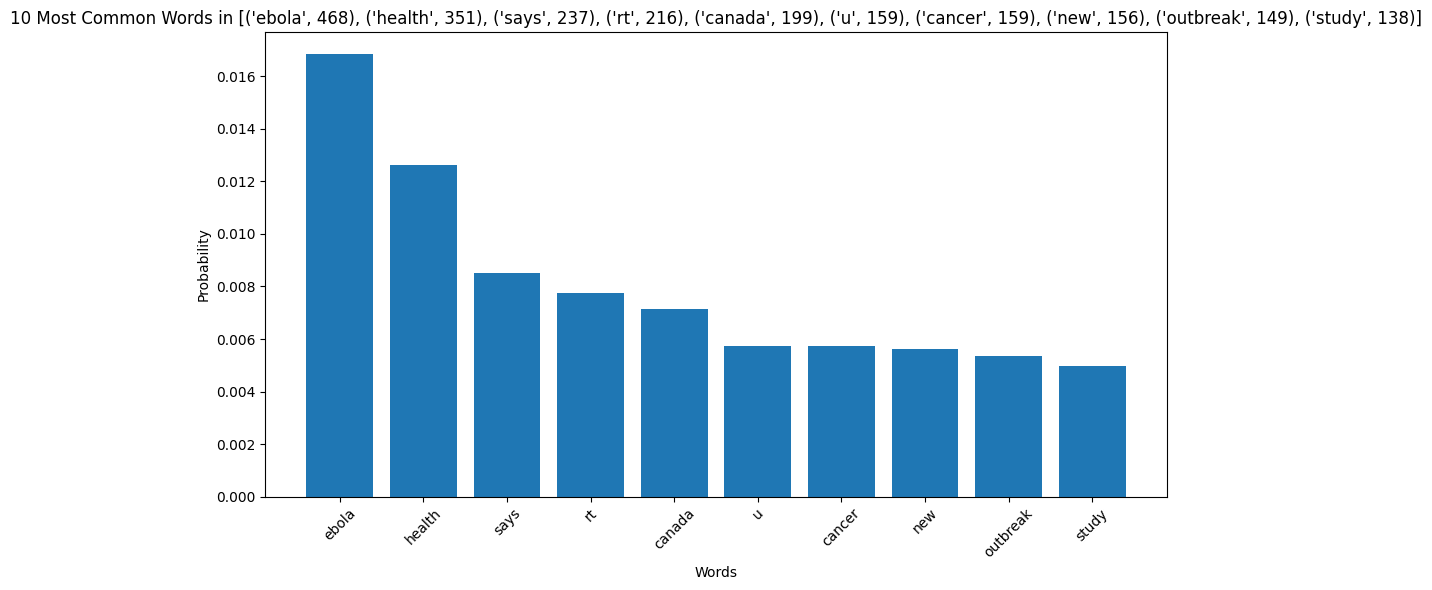

cnnhealth
[0.020441901128596406, 0.008202193609918931, 0.00817040216181847, 0.006644412652996344, 0.006390081068192656, 0.006167540931489429, 0.00584962645048482, 0.005340963280877444, 0.005277380384676522, 0.004991257351772373]


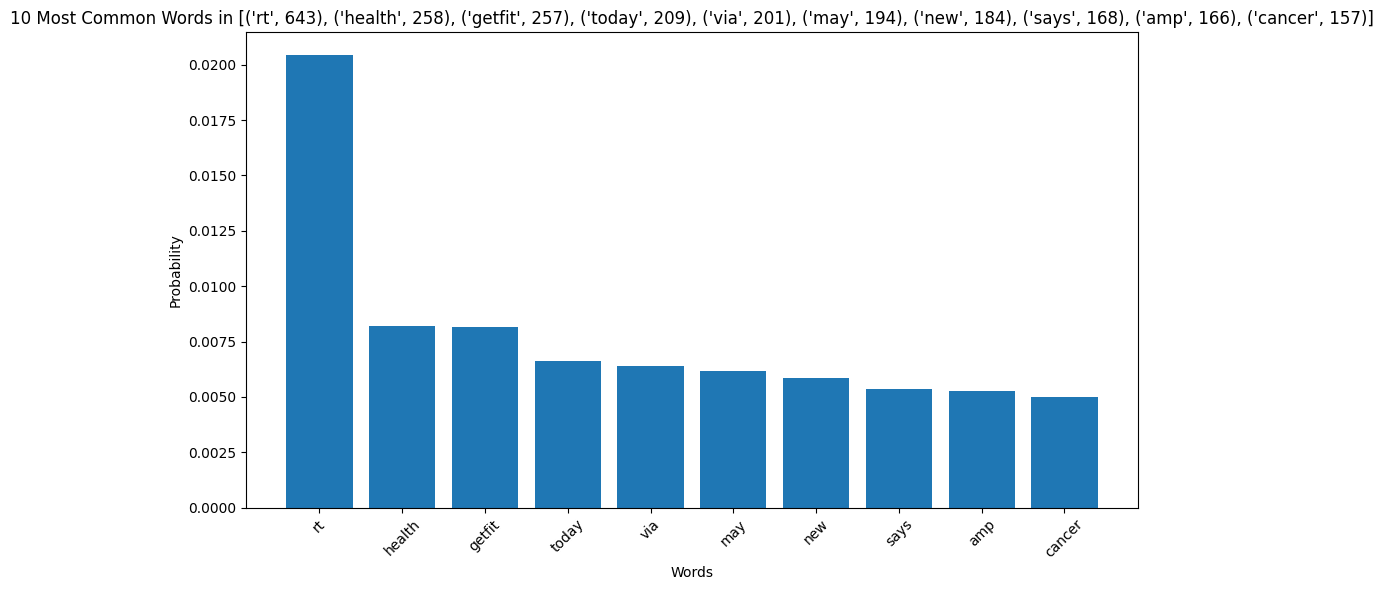

everydayhealth
[0.03459476382420851, 0.024458967635894023, 0.009900990099009901, 0.008531287911399836, 0.006848510938050327, 0.00626149571478887, 0.00622236136657144, 0.005791883536179705, 0.005752749187962275, 0.005674480491527413]


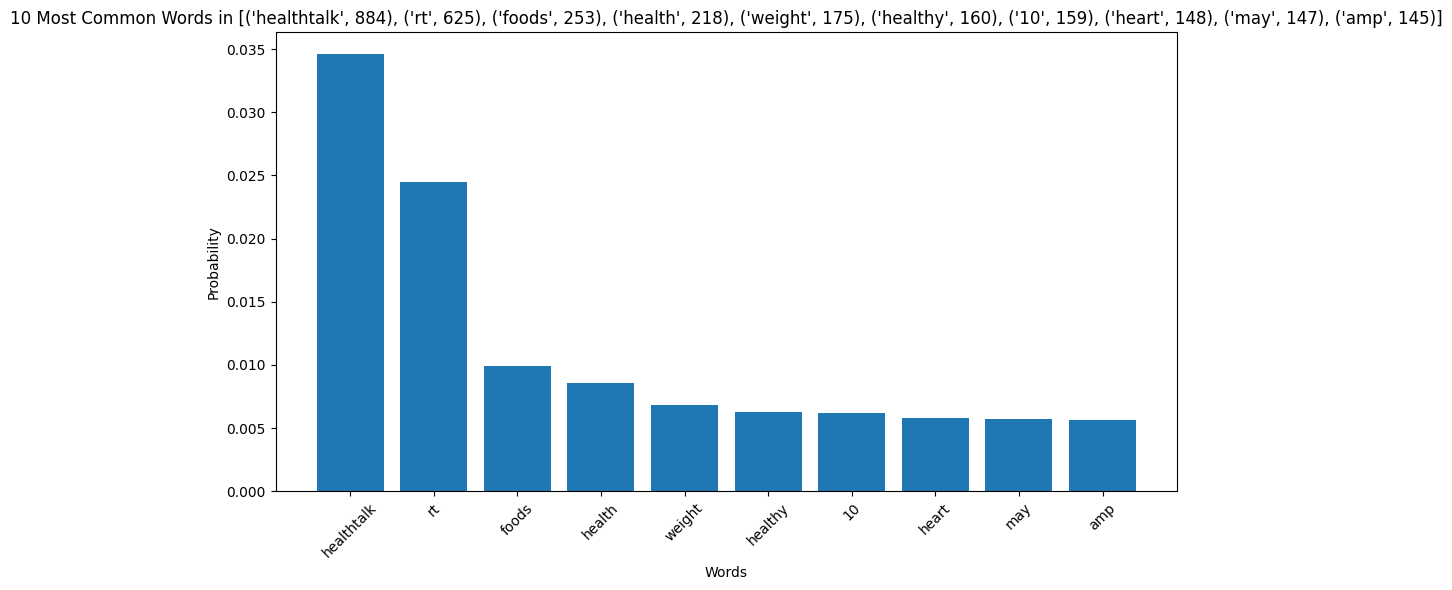

foxnewshealth
[0.014258028792912514, 0.013635105204872646, 0.011004983388704318, 0.010935769656699889, 0.009759136212624584, 0.007129014396456257, 0.005952380952380952, 0.005606312292358804, 0.005329457364341085, 0.005052602436323367]


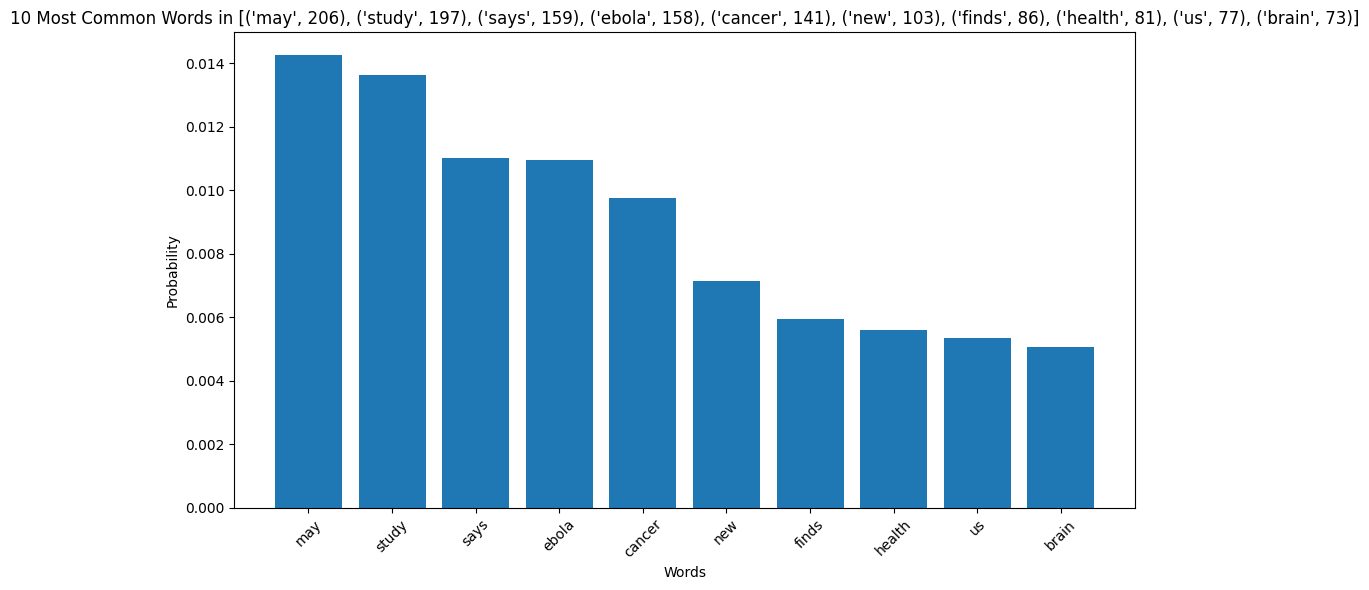

gdnhealthcare
[0.05138495717920235, 0.026194144838212634, 0.011681656931952557, 0.011538323718063568, 0.009997491668756943, 0.009854158454867954, 0.008994159171534023, 0.007381660515282904, 0.007166660694449422, 0.006879994266671445]


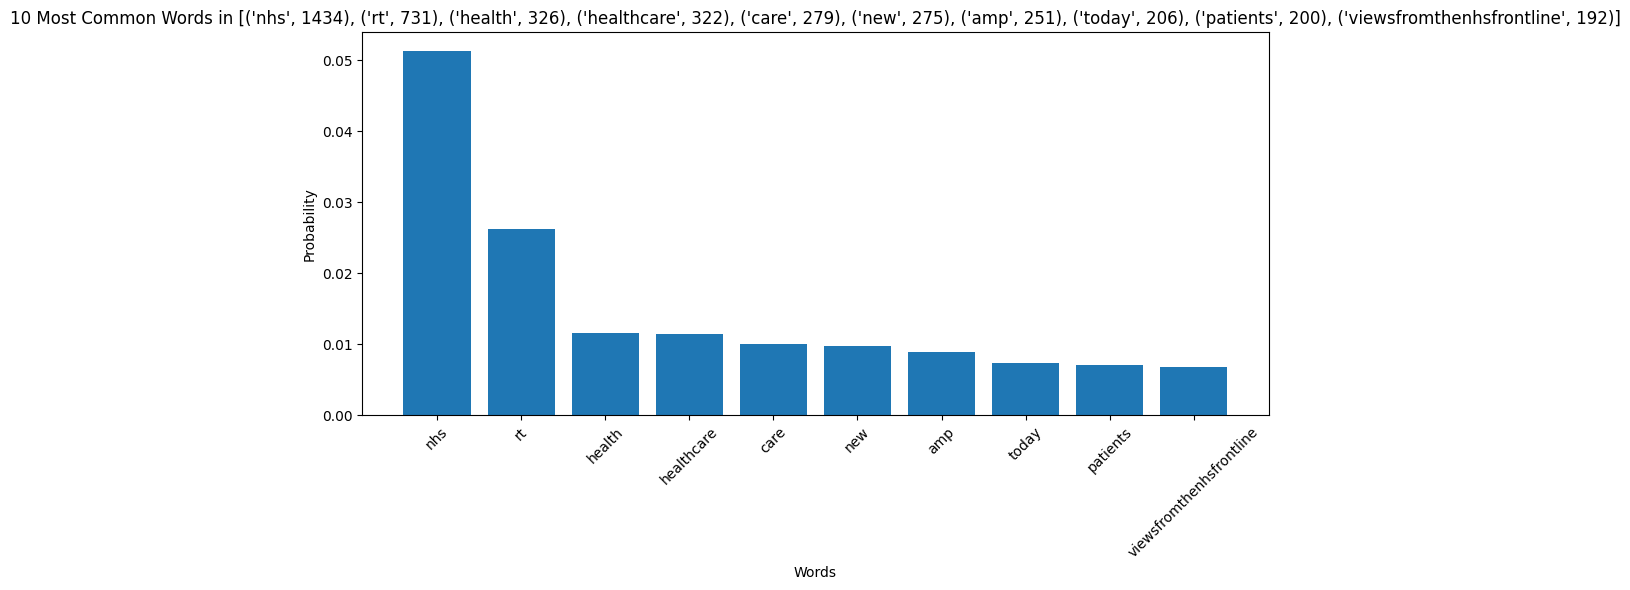

goodhealth
[0.017073785646254693, 0.008473864082021401, 0.007395372289764133, 0.007255308420639811, 0.006050759146170654, 0.006008739985433357, 0.005882682503221469, 0.005840663342484172, 0.005784637794834444, 0.005742618634097149]


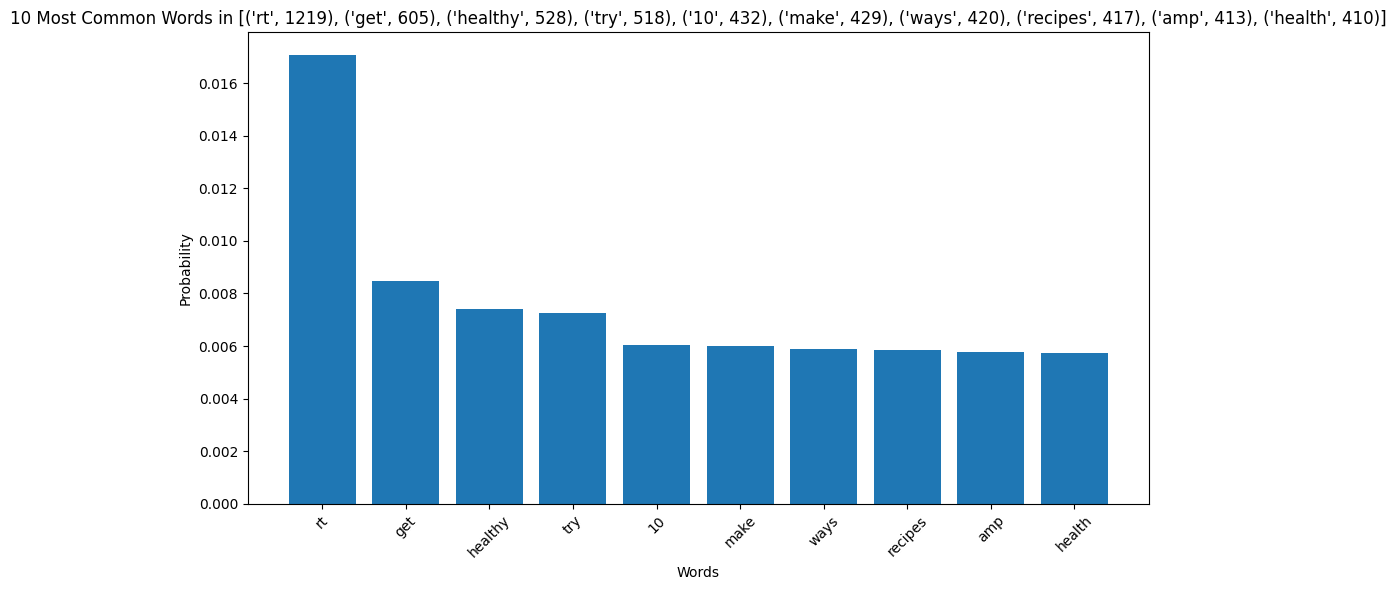

latimeshealth
[0.01329180801957622, 0.010483287915021412, 0.00931538846560258, 0.00867582448139703, 0.00728546799399366, 0.006006340025582559, 0.005811690117346087, 0.004755019186919526, 0.004755019186919526, 0.004671597797675324]


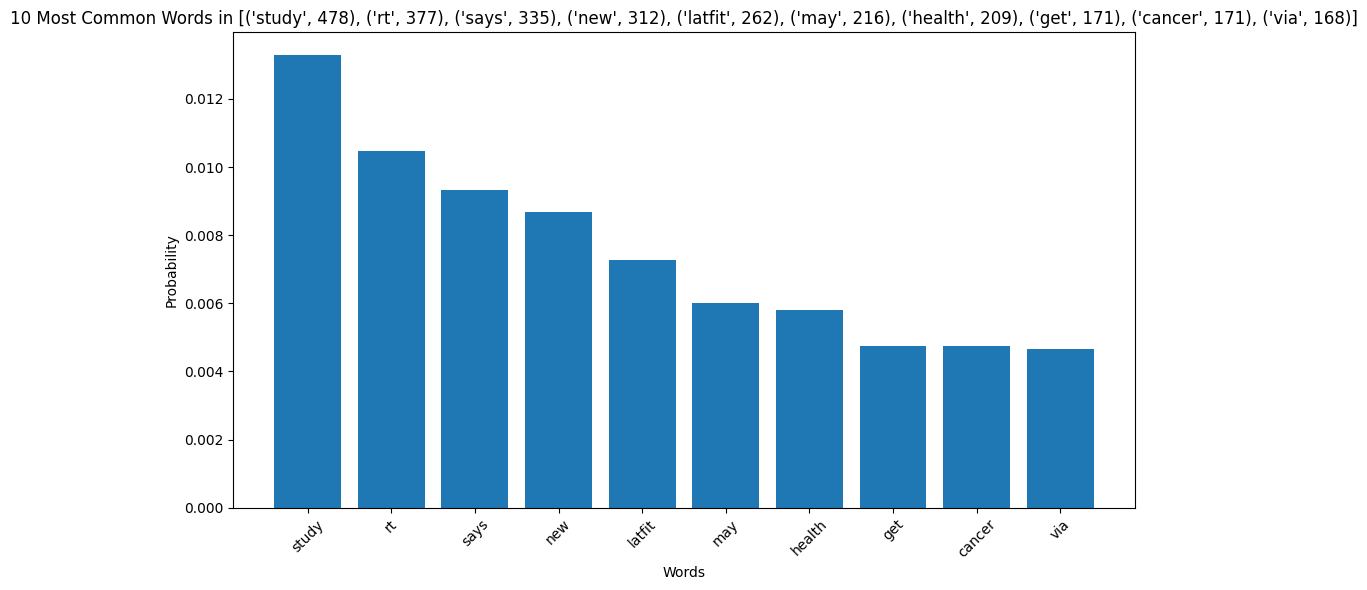

msnhealthnews
[0.03546660460786595, 0.030346753548987665, 0.015359553176634861, 0.01438212706539446, 0.010146613916686061, 0.009634628810798232, 0.007819408889923203, 0.007726320688852688, 0.007447056085641145, 0.007353967884570631]


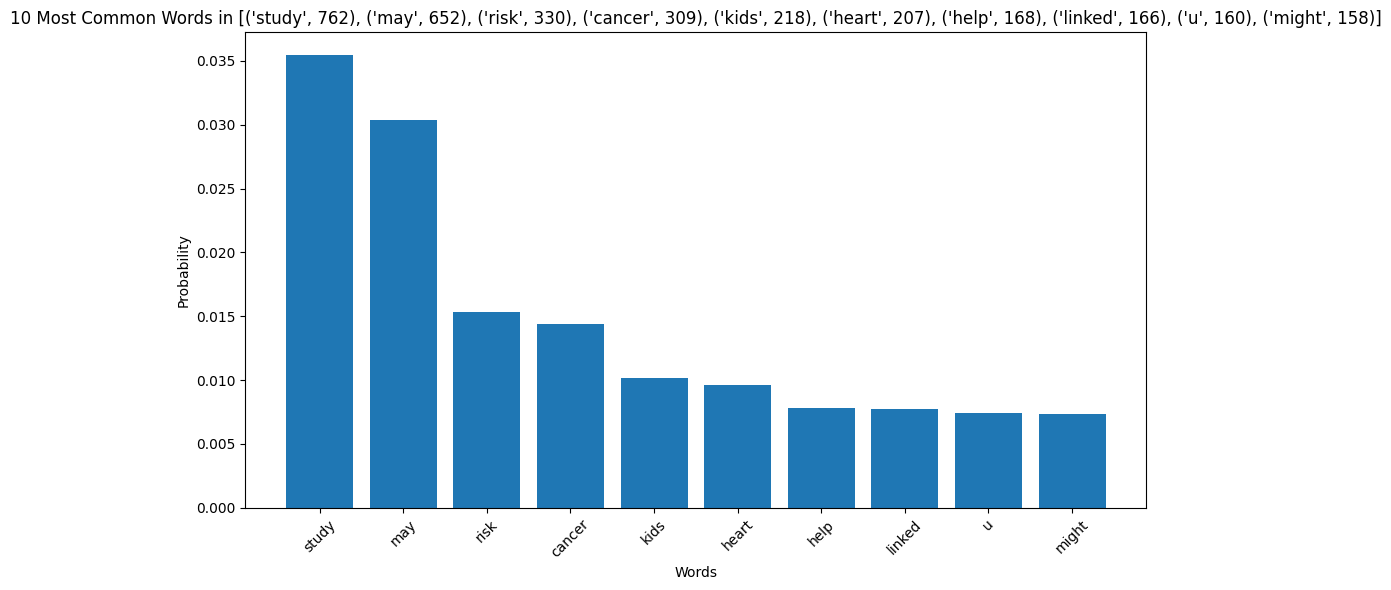

nprhealth
[0.016707960104186518, 0.015056222603392415, 0.007019884378374945, 0.006289308176100629, 0.006289308176100629, 0.005495203608411155, 0.004828155771551998, 0.004542278127183787, 0.004256400482815577, 0.00416110793469284]


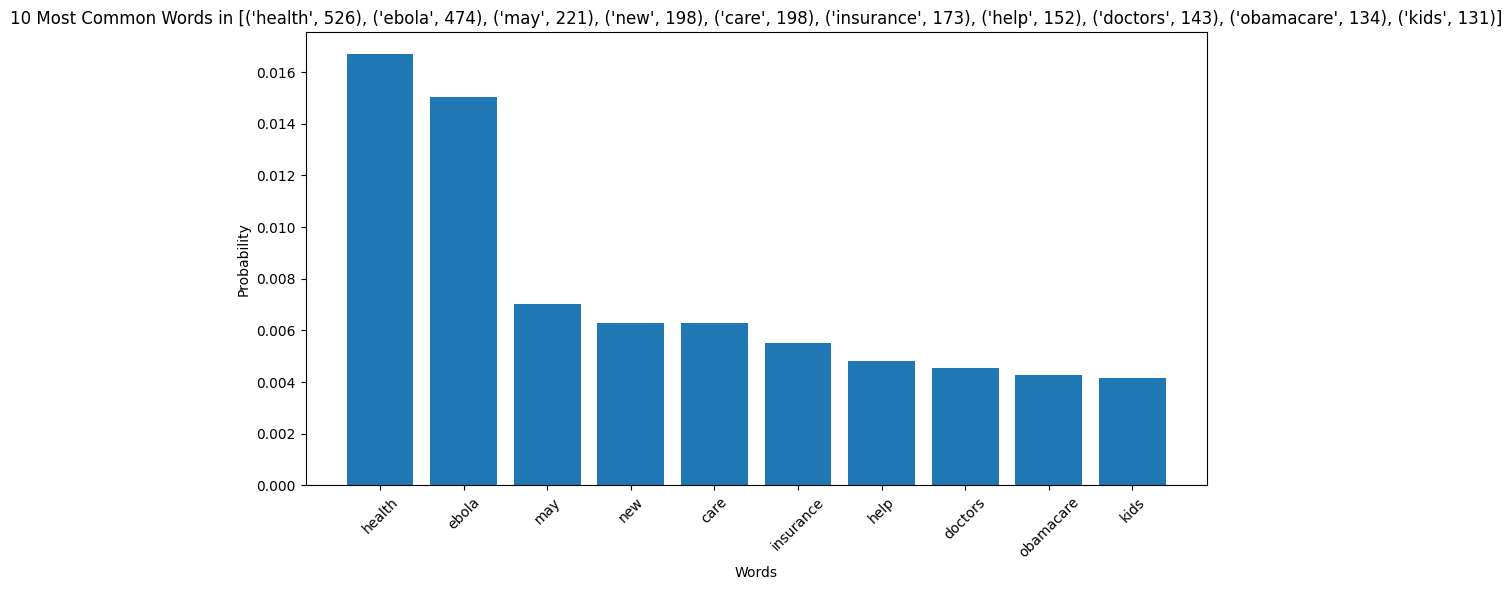

nytimeshealth
[0.028678849348605404, 0.019804144443472938, 0.014798461134913002, 0.014711025618606278, 0.014383142432456064, 0.006273498295007432, 0.006164203899624027, 0.006142345020547346, 0.005814461834397132, 0.005333566494710151]


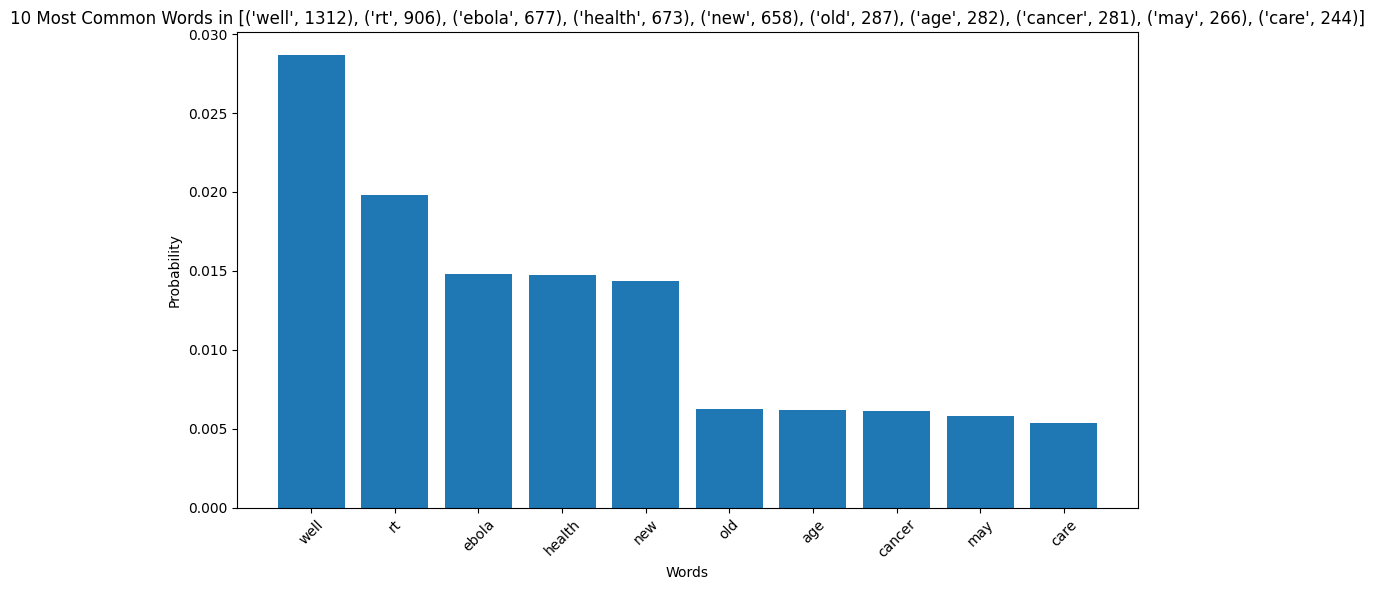

reuters_health
[0.03868806397579294, 0.020127519317015185, 0.012670881288161236, 0.009455881558329281, 0.008456259793591613, 0.007834873291187119, 0.007510671637758686, 0.006132814610687848, 0.00605176419733074, 0.005268276868212028]


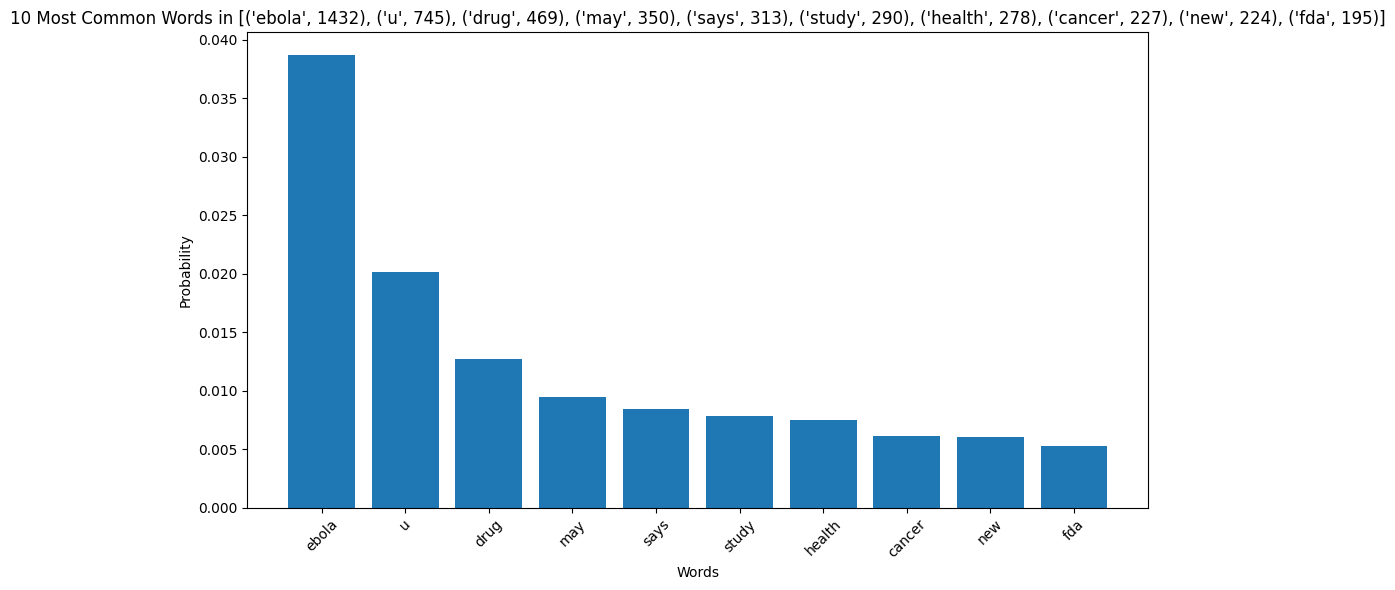

usnewshealth
[0.028232636928289104, 0.010540184453227932, 0.008375682288725766, 0.008281573498964804, 0.006775832862789385, 0.006681724073028421, 0.006493506493506494, 0.006211180124223602, 0.006117071334462639, 0.006022962544701675]


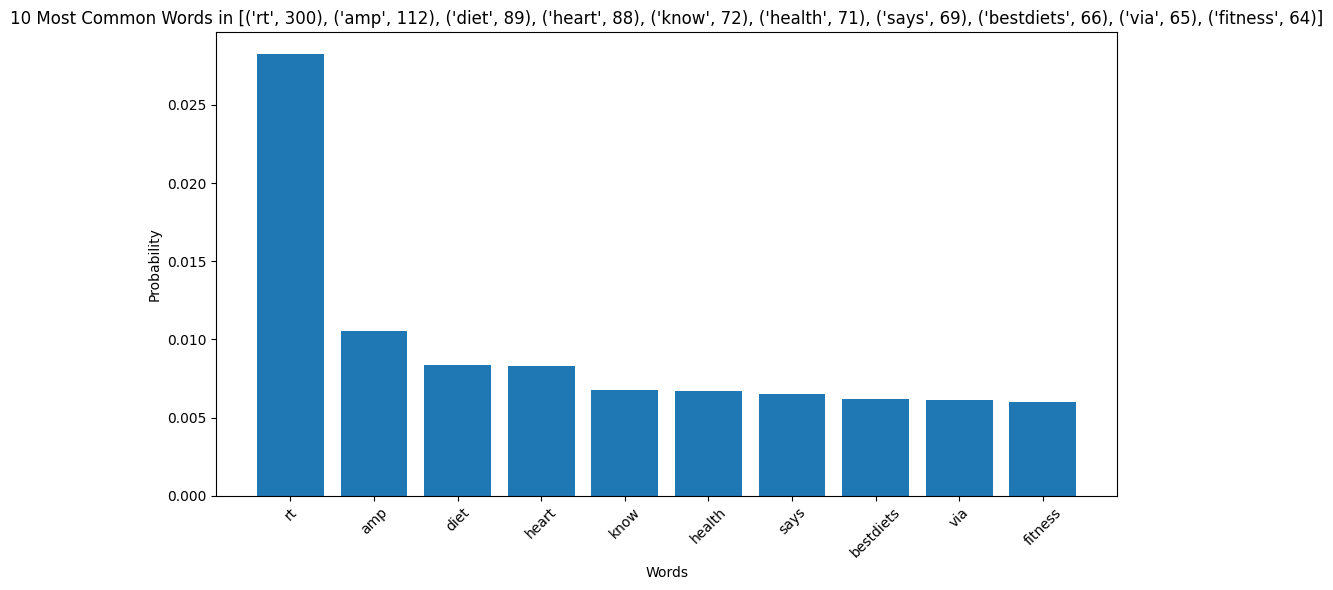

wsjhealth
[0.06947227788911156, 0.016092791643893847, 0.010870225299083014, 0.010354041416165664, 0.008926944798688285, 0.007682030728122912, 0.007560575696848242, 0.007287301876480233, 0.00695330054047489, 0.006437116657557539]


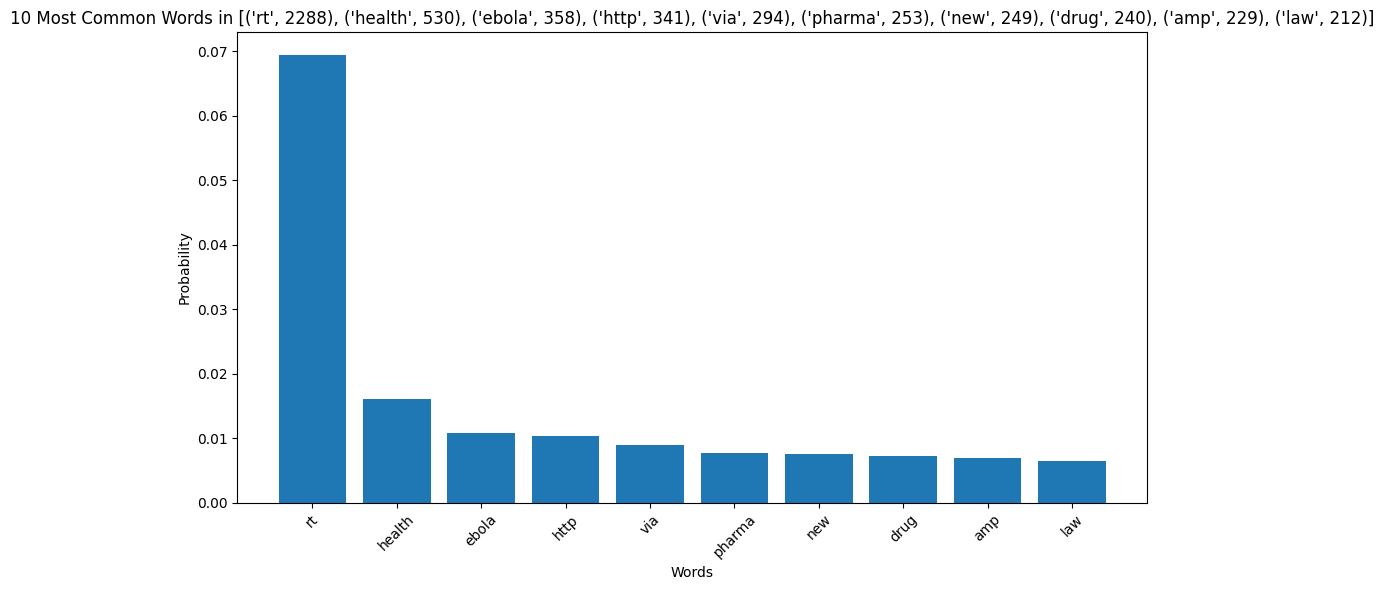

In [ ]:
for account, tweet in grouped_df.iterrows():
    cnt = Counter(tweet['nostopword_cleaned_tokenized_tweet'])
    print(account)
    plot_word_probabilities(cnt.most_common(10),sum(cnt.values()))

##### CLUSTERING TASK

###### Combine tweets from all 16 accounts and cluster the tweets with K-means clustering, using K = 16

In [ ]:
df.head()

account            tweet_id                       date_time  \
0  cbchealth  586266687948881921  Thu Apr 09 20:37:25 +0000 2015   
1  cbchealth  586266687017771008  Thu Apr 09 20:37:25 +0000 2015   
2  cbchealth  586266685495214080  Thu Apr 09 20:37:24 +0000 2015   
3  cbchealth  586226316820623360  Thu Apr 09 17:57:00 +0000 2015   
4  cbchealth  586164344452354048  Thu Apr 09 13:50:44 +0000 2015   

                                                                                                                                                                                                             tweet  \
0                                   Drugs need careful monitoring for expiry dates, pharmacists say http://www.cbc.ca/news/health/drugs-need-careful-monitoring-for-expiry-dates-pharmacists-say-1.3026749?cmp=rss   
1                                                                                                       Sabra hummus recalled in U.S. http://www.cbc.ca/news/health/sabra-hummus-recalled-in-u-s-1.3026865?cmp=rss   
2    U.S. sperm bank sued by Canadian couple didn't verify donor info, executive says http://www.cbc.ca/news/canada/toronto/sperm-bank-sued-by-port-hope-couple-says-it-didn-t-verify-donor-info-1.3026909?cmp=rss   
3                                           Manitoba pharmacists want clampdown on Tylenol 1 sales http://www.cbc.ca/news/canada/manitoba/manitoba-pharmacists-want-clampdown-on-tylenol-1-sales-1.3025636?cmp=rss   
4  Mom of 7 'spooked' by vaccinations reverses stand â but then kids get sick http://www.cbc.ca/news/canada/ottawa/tara-hills-ottawa-mom-changes-anti-vaccination-stand-before-7-kids-get-sick-1.3025592?cmp=rss   

                                                                    cleaned_tweet  \
0                  drugs need careful monitoring for expiry dates pharmacists say   
1                                                   sabra hummus recalled in u s    
2  u s sperm bank sued by canadian couple didn t verify donor info executive says   
3                          manitoba pharmacists want clampdown on tylenol 1 sales   
4          mom of 7 spooked by vaccinations reverses stand but then kids get sick   

                                                                          tokenized_cleaned_tweet  \
0                        [drugs, need, careful, monitoring, for, expiry, dates, pharmacists, say]   
1                                                             [sabra, hummus, recalled, in, u, s]   
2  [u, s, sperm, bank, sued, by, canadian, couple, didn, t, verify, donor, info, executive, says]   
3                                 [manitoba, pharmacists, want, clampdown, on, tylenol, 1, sales]   
4            [mom, of, 7, spooked, by, vaccinations, reverses, stand, but, then, kids, get, sick]   

                                               nostopword_cleaned_tokenized_tweet  
0             [drugs, need, careful, monitoring, expiry, dates, pharmacists, say]  
1                                                    [sabra, hummus, recalled, u]  
2  [u, sperm, bank, sued, canadian, couple, verify, donor, info, executive, says]  
3                     [manitoba, pharmacists, want, clampdown, tylenol, 1, sales]  
4               [mom, 7, spooked, vaccinations, reverses, stand, kids, get, sick]

In [ ]:
all_tweets = df["cleaned_tweet"]

In [ ]:
all_tweets.head()

0                    drugs need careful monitoring for expiry dates pharmacists say
1                                                     sabra hummus recalled in u s 
2    u s sperm bank sued by canadian couple didn t verify donor info executive says
3                            manitoba pharmacists want clampdown on tylenol 1 sales
4            mom of 7 spooked by vaccinations reverses stand but then kids get sick
Name: cleaned_tweet, dtype: object

In [ ]:
# create TFIDF vectorizer
vectorizer = TfidfVectorizer(stop_words='english')
vectorized_tweets = vectorizer.fit_transform(all_tweets)

In [ ]:
# Reduce dimensionality using LSA (Latent Semantic Analysis)
lsa = TruncatedSVD(n_components=2)
lsa_matrix = lsa.fit_transform(vectorized_tweets)

Initial choice for dimensionality reduction was PCA. However, it did not stop running for over 45 minutes and ultimately, upon further research, I decided to use LSA. I picked the idea from an article which was doing a very similar analysis.

In [ ]:
# Perform K-Means clustering
k = 16
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(lsa_matrix)

KMeans(n_clusters=16, random_state=42)

In [ ]:
lsa_matrix.shape

(63112, 2)

In [ ]:
# create a dataframe to store the results
kmeans_results = pd.DataFrame()
kmeans_results['tweet'] = all_tweets
kmeans_results['cluster'] = kmeans.labels_

In [ ]:
# print the results
print(kmeans_results.sample(5))

                                                                                          tweet  \
48266                 more high deductible plan members can t pay hospital bills looks into it    
24966  nina s bf said you d look better if you lost weight so she dumped him amp the extra lbs    
6652                   rt five takeaways on new health care projections washington wire wsj via   
42535                                                      putting fitness trackers to the test   
61726                            alzheimer s med seems ineffective in those with down syndrome    

       cluster  
48266        5  
24966        5  
6652        15  
42535        9  
61726        0  


In [ ]:
labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

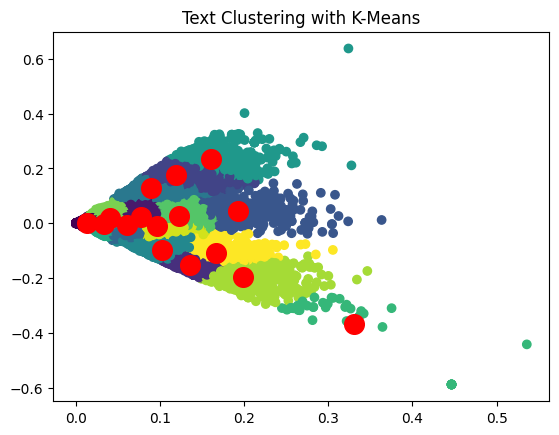

In [ ]:
#plt.figure(figsize=(10, 8))
plt.scatter(lsa_matrix[:, 0], lsa_matrix[:, 1], c=labels, cmap='viridis')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1,], s=200, c='red')
plt.title("Text Clustering with K-Means")
plt.show()

Sources: 1. https://medium.com/@evertongomede/clustering-text-in-natural-language-processing-unveiling-patterns-and-insights-8c3cd137b135#:~:text=Text%20Clustering%20Methodologies&text=K%2DMeans%20Clustering%3A%20K%2D,a%20group%20of%20similar%20documents.
2. https://www.geeksforgeeks.org/clustering-text-documents-using-k-means-in-scikit-learn/

###### Try to improve the results by either changing the value of K, or by using an entirely different clustering algorithm (e.g., agglomerative), or by changing the distance function in a meaningful way.

In [ ]:
# Perform K-Means clustering
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(lsa_matrix)

KMeans(n_clusters=3, random_state=42)

In [ ]:
# create a dataframe to store the results
kmeans_results2 = pd.DataFrame()
kmeans_results2['tweet'] = all_tweets
kmeans_results2['cluster'] = kmeans.labels_

In [ ]:
labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

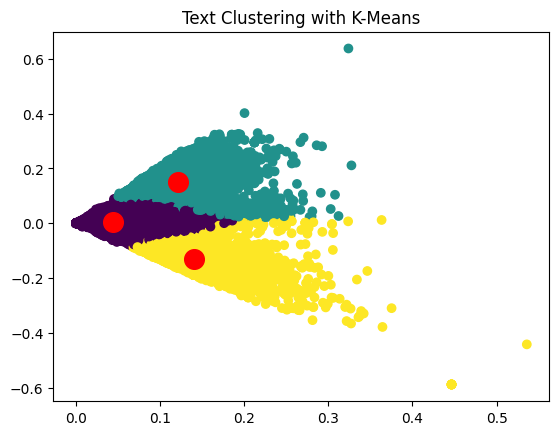

In [ ]:
#plt.figure(figsize=(10, 8))
plt.scatter(lsa_matrix[:, 0], lsa_matrix[:, 1], c=labels, cmap='viridis')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1,], s=200, c='red')
plt.title("Text Clustering with K-Means")
plt.show()

###### Aglomerative

In [ ]:
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering

In [ ]:
model = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='single')

In [ ]:
model.fit(lsa_matrix)

AgglomerativeClustering(affinity='euclidean', linkage='single', n_clusters=5)

In [ ]:
labels = model.labels_

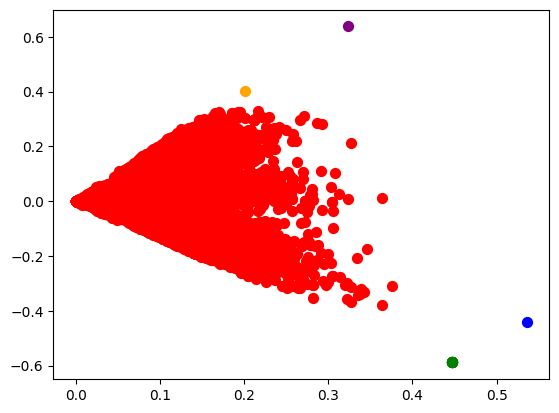

In [ ]:
plt.scatter(lsa_matrix[labels==0, 0], lsa_matrix[labels==0, 1], s=50, marker='o', color='red')
plt.scatter(lsa_matrix[labels==1, 0], lsa_matrix[labels==1, 1], s=50, marker='o', color='blue')
plt.scatter(lsa_matrix[labels==2, 0], lsa_matrix[labels==2, 1], s=50, marker='o', color='green')
plt.scatter(lsa_matrix[labels==3, 0], lsa_matrix[labels==3, 1], s=50, marker='o', color='purple')
plt.scatter(lsa_matrix[labels==4, 0], lsa_matrix[labels==4, 1], s=50, marker='o', color='orange')
plt.show()